In [1]:
import os 
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./models/')
from useful_functions import df_to_dict, concat_dico, get_classement, sort_list


In [2]:
models1Dnames=['Moving Average','ARIMA', 'Exponential', 'Linear Regression', 'Bayesian Regression','SIRH1', 'SIRH2', 'SIRH3', 'SIRH4']
models3Dnames=[ 'VAR', 'Exponential Multi', 'SIRH Multi1', 'SIRH Multi2','SEIR Mob']
list_of_models= models1Dnames+models3Dnames
print(list_of_models)

['Moving Average', 'ARIMA', 'Exponential', 'Linear Regression', 'Bayesian Regression', 'SIRH1', 'SIRH2', 'SIRH3', 'SIRH4', 'VAR', 'Exponential Multi', 'SIRH Multi1', 'SIRH Multi2', 'SEIR Mob']


In [3]:
def classify_bis(point, r_effs):  # Classification based on transmission dynamics

    if r_effs[point] < 0.5:
        return 'minimal transmission'
    elif r_effs[point] < 0.8:
        return 'low transmission'
    elif r_effs[point] < 1.2:
        return 'stable'
    elif r_effs[point] < 3:
        return 'high transmission'
    else:
        return 'very high transmission'

In [27]:
model_type='1D'
loss='WIS'
reach='7'
list_of_models= models1Dnames+models3Dnames
type_of_points=['all','very high transmission', 'high transmission' , 'stable',  'low transmission', 'minimal transmission']

for loss in ['WIS']: #'WIS' 
    for reach in ['14']: #'14'
        df_expected_ranks=pd.DataFrame(columns= list_of_models, index = type_of_points )

        for label_point in type_of_points:

            all_ranks=np.zeros((len(list_of_models), len(list_of_models)))
            results_list=[ name for name in os.listdir('./results/global_evaluation/') if loss in name and '1D' in name and 'reach_='+str(reach) in name   ] # results of the models
            for name in results_list :
                mob=int(name.split('_')[-5])
                pand=int(name.split('_')[-4])
                with open('./results/global_evaluation/'+name, 'r') as f:
                    dicoresults1 = json.load(f)
                with open('./results/global_evaluation/'+name.replace('1D', '3D'), 'r') as f:
                    dicoresults2 = json.load(f)
                dicoresults=concat_dico(dicoresults1, dicoresults2)
                df=pd.read_csv('./all_pandemics/pandemic_'+name.split('_')[-5]+'_'+name.split('_')[-4]+'.csv')
                df.index=['n_hospitalized', 'n_infectious', 'mobility', 'r_eff']
                df.drop(['Unnamed: 0'], axis=1, inplace=True)
                n_hospitalized = np.array(df.loc['n_hospitalized'])
                r_eff=np.array(df.loc['r_eff'])
                indexs_points=[[20*i] for i in range(1, 15) ] 
                prediction=pd.read_csv('./results/predictions_of_the_models/predictions_'+str(reach)+'_days_on_pandemic_'+str(mob)+'_'+str(pand)+'.csv')
                prediction.drop(['Unnamed: 0'], axis=1, inplace=True)
                prediction.index=[20*i for i in range(1, 15)]
                #prediction_bis=prediction.drop(['Real values', 'Exponential', 'Exponential Multi'], axis=1)
                prediction_all=prediction
                #prediction=prediction_bis
                for point in indexs_points: 
                    if n_hospitalized[point[0]] >= 10:
                        if label_point=='all': 
                            real_value=prediction_all['Real values'].loc[point[0]]
                            perfs=dicoresults[str(point)]
                            #assert(len(perfs)==14)
                            #assert(abs(perfs[2] - perfs[11]) < 0.001, (perfs[2], perfs[11])) 
                            #perfs.pop(11) # remove the moving average multi
                            #assert(len(perfs)==13)
                            rankings=get_classement(perfs)
                            for i in range(len(rankings)): 
                                rank_model_i=rankings[i]
                                all_ranks[i][rank_model_i]+=1

                        elif classify_bis(point[0], r_eff) == label_point :
                            real_value=prediction_all['Real values'].loc[point[0]]
                            perfs=dicoresults[str(point)]
                            #assert(len(perfs)==14)
                            #assert(abs(perfs[2] - perfs[11]) < 0.001, (perfs[2], perfs[11])) 
                            #perfs.pop(11) # remove the moving average multi
                            #assert(len(perfs)==13)
                            rankings=get_classement(perfs)
                            for i in range(len(rankings)): 
                                rank_model_i=rankings[i]
                                all_ranks[i][rank_model_i]+=1
            expected_ranks=[np.sum((np.array(all_ranks[i])/np.sum(np.array(all_ranks[i])))*np.array([i for i in range( len(rankings))])) for i in range(len(rankings))]    
            df_expected_ranks.loc[label_point]=expected_ranks
                
                        

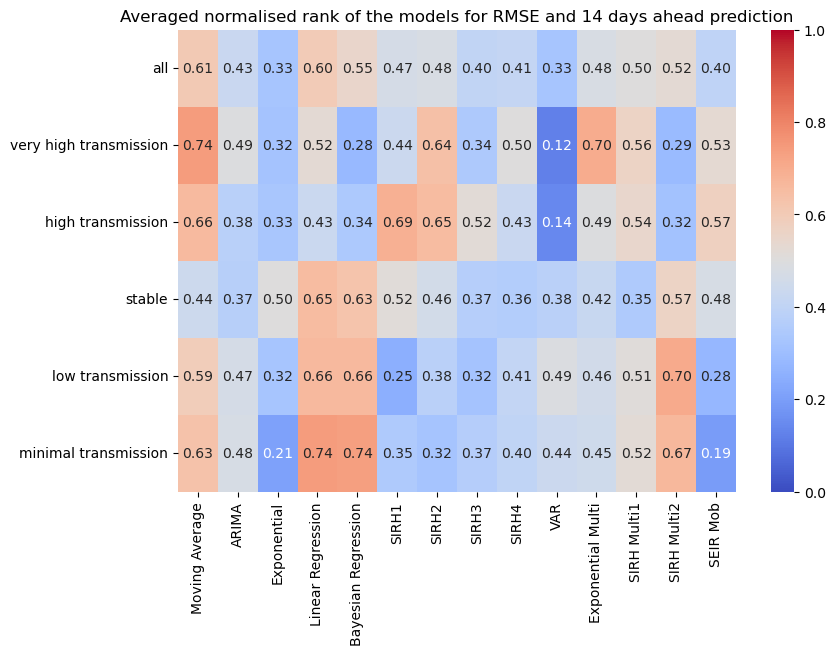

In [28]:
plt.figure(figsize=(9,6))
sns.heatmap(df_expected_ranks.astype(float)/len(list_of_models), cmap='coolwarm', annot=True, fmt=".2f", vmin=0, vmax=1)
xticks = list_of_models
yticks = type_of_points
plt.xticks(ticks=[i+0.5 for i in range(len(xticks))], labels=xticks, rotation=90)
plt.yticks(ticks=[i+0.5 for i in range(len(yticks))], labels=yticks, rotation=0)
plt.title('Averaged normalised rank of the models for '+str(loss)+' and '+str(reach)+' days ahead prediction')
plt.savefig('heatmap_'+str(loss)+'_'+str(reach)+'.pdf', bbox_inches='tight')

In [7]:
def process_row(row):
    smallest_indices = row.nsmallest(5).index  # Get the 5 smallest value indices
    row_transformed = pd.Series(0, index=row.index)  # Initialize row with zeros
    row_transformed[smallest_indices] = 1 / row[smallest_indices]  # Invert smallest values
    total_sum = row_transformed.sum()
    if total_sum > 0:
        row_transformed /= total_sum
    return row_transformed

In [12]:
df_ranks=df_expected_ranks.copy()
df_ranks = df_ranks.apply(pd.to_numeric, errors='coerce')
df_ranks = df_ranks.apply(process_row, axis=1)
print(df_ranks)
df_ranks.to_csv('./ranks_for_ensemble_wis_14.csv')

                        Moving Average     ARIMA  Exponential  \
all                           0.000000  0.196295          0.0   
very high transmission        0.000000  0.000000          0.0   
high transmission             0.000000  0.174950          0.0   
stable                        0.173603  0.218481          0.0   
low transmission              0.000000  0.000000          0.0   
minimal transmission          0.000000  0.000000          0.0   

                        Linear Regression  Bayesian Regression     SIRH1  \
all                              0.000000             0.000000  0.000000   
very high transmission           0.000000             0.192934  0.128898   
high transmission                0.129155             0.160986  0.000000   
stable                           0.000000             0.000000  0.000000   
low transmission                 0.000000             0.000000  0.244221   
minimal transmission             0.000000             0.000000  0.165360   

           

/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_15043/787612692.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.24835808 0.20277438 0.19730052 0.19344973 0.16324137]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  row_transformed[smallest_indices] = 1 / row[smallest_indices]  # Invert smallest values
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_15043/787612692.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63461538 0.29577465 0.21428571 0.19760479 0.19075145]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  row_transformed[smallest_indices] = 1 / row[smallest_indices]  # Invert smallest values
/var/folders/vq/kbhqcbz52js6b8nz5zvnryc1fy9f2x/T/ipykernel_15043/787612692.py:4: FutureWarning: Setting an item of incompatible dtyp

14
